# Where should we put taxi station in New York city ?

## 1- Problem description

In this hands on, we will explore data about taxi in New York city. The purpose is to understand taxi behaviour,  generate some insights about the pattern of rides amount throughout the day across the city and suggest the best locations for futur taxi stops where people can get picked up/dropped off by cabs and wait for cabs to pick them up.

## 2- Data

<img src="taxi.png">

We will be using the training data from 'the New York City Taxi Trip Duration DataSet': https://www.kaggle.com/c/nyc-taxi-trip-duration/data that can be obtained from Kaggle. Datase includes pickup time, geo-coordinates, number of passengers, and several other variables.

Train data is downloaded into 'data_used/nyc_taxi_data.csv'



## 3- Read data

In [336]:
# import librairies
import numpy as np 
import pandas as pd 
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [337]:
# Some set up:
np.random.seed(1987)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = [8,8]

In [338]:
# Read data:
nyc_taxi_data = pd.read_csv('../data_used/nyc_taxi_data.csv')

## 4- First data exploration & cleaning 

In [339]:
# Display the first 5 lines of data
nyc_taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()


In [340]:
# Display data info
nyc_taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [341]:
# Display data description 
nyc_taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [342]:
# Trip duration clean-up

As we noted earlier there are some outliers associated with the `trip_duration` variable, specifically a 980 hour maximum trip duration and a minimum of 1 second trip duration. We decided to exclude data that lies outside 2 standard deviations from the mean.

In [343]:
m = np.mean(nyc_taxi_data['trip_duration'])
s = np.std(nyc_taxi_data['trip_duration'])
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['trip_duration'] <= m + 2*s]
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['trip_duration'] >= m - 2*s]

In [344]:
# Latitude and Longitude clean-up

Looking into it, the borders of New York city, in coordinates comes out to be:
- City_long_border = (-74.03, -73.75)
- City_lat_border = (40.63, 40.85) 

In [345]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
nyc_taxi_data = nyc_taxi_data[(nyc_taxi_data.pickup_longitude> xlim[0]) & (nyc_taxi_data.pickup_longitude < xlim[1])]
nyc_taxi_data = nyc_taxi_data[(nyc_taxi_data.dropoff_longitude> xlim[0]) & (nyc_taxi_data.dropoff_longitude < xlim[1])]
nyc_taxi_data = nyc_taxi_data[(nyc_taxi_data.pickup_latitude> ylim[0]) & (nyc_taxi_data.pickup_latitude < ylim[1])]
nyc_taxi_data = nyc_taxi_data[(nyc_taxi_data.dropoff_latitude> ylim[0]) & (nyc_taxi_data.dropoff_latitude < ylim[1])]

In [346]:
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['pickup_longitude'] <= -73.75]
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['pickup_longitude'] >= -74.03]
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['pickup_latitude'] <= 40.85]
nyc_taxi_data = nyc_taxi_data[nyc_taxi_data['pickup_latitude'] >= 40.63]

In [347]:
# Date format clean-up

In [348]:
nyc_taxi_data['pickup_datetime'] = pd.to_datetime(nyc_taxi_data.pickup_datetime)
nyc_taxi_data.loc[:, 'pickup_date'] = nyc_taxi_data['pickup_datetime'].dt.date
nyc_taxi_data['dropoff_datetime'] = pd.to_datetime(nyc_taxi_data.dropoff_datetime) 

In [349]:
# Create columns month, week, day and hour:
nyc_taxi_data['month'] = nyc_taxi_data.pickup_datetime.apply(lambda x: x.month)
nyc_taxi_data['week'] = nyc_taxi_data.pickup_datetime.apply(lambda x: x.week)
nyc_taxi_data['day'] = nyc_taxi_data.pickup_datetime.apply(lambda x: x.day)
nyc_taxi_data['hour'] = nyc_taxi_data.pickup_datetime.apply(lambda x: x.hour)

In [350]:
# Display new cleaned data 
nyc_taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,month,week,day,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14,3,11,14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12,6,23,12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19,1,3,19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06,4,14,6,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26,3,12,26,13


In [351]:
# Plot trip_duration distribution using hist()

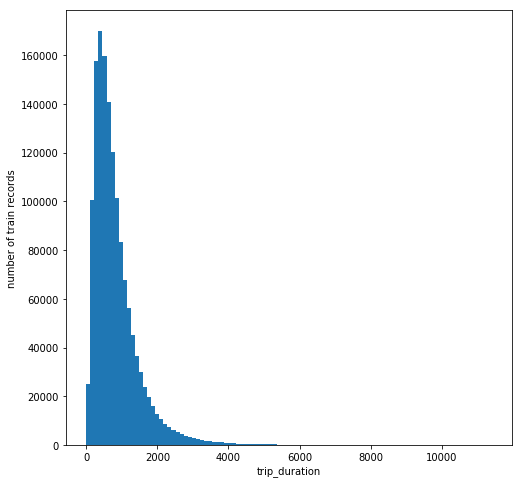

In [352]:
plt.hist(nyc_taxi_data['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

We see that major trip duration are less than 2000s 

In [353]:
# plot the evolution of number of trips over time

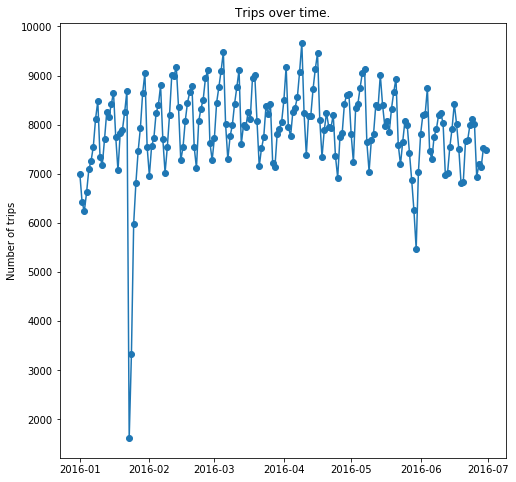

In [354]:
plt.plot(nyc_taxi_data.groupby('pickup_date').count()[['id']], 'o-')
plt.title('Trips over time.')
plt.ylabel('Number of trips')
plt.show()

Around 8000 trips per day in New York city !!

## 5- Data Visualization using matpolotlib & Folium

In [355]:
# Let's have a look to drop off and pick up locations

In [ ]:
longitude = list(nyc_taxi_data.pickup_longitude) + list(nyc_taxi_data.dropoff_longitude)
latitude = list(nyc_taxi_data.pickup_latitude) + list(nyc_taxi_data.dropoff_latitude)

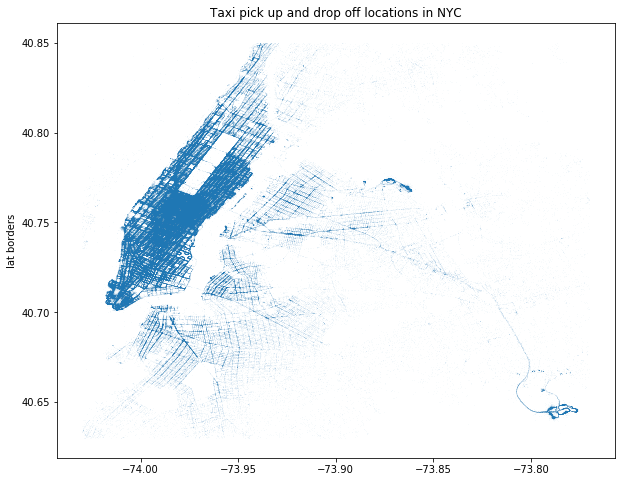

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.title('Taxi pick up and drop off locations in NYC')
plt.ylabel('long borders')
plt.ylabel('lat borders')
plt.show()

In [ ]:
# Display NYC map with Folium:

In [ ]:
# Function to generate a new New York City map
def generateNYCmap(default_location=[40.737595, -73.993647],default_width='80%', default_height='80%', default_zoom_start=11):
    base_map = folium.Map(location=default_location,width=default_width, height=default_height, control_scale=True,zoom_control=True, zoom_start=default_zoom_start)
    return base_map

In [ ]:
nyc_map = generateNYCmap()
nyc_map

In [ ]:
# Create Heatmap of pick up and drop off locations (use HeatMap from folium.plugins)

In [ ]:
from folium.plugins import HeatMap

In [ ]:
df_heatMap = nyc_taxi_data[nyc_taxi_data.month>4]

In [ ]:
data = df_heatMap[['pickup_latitude', 'pickup_longitude']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()

In [ ]:
HeatMap(data, radius=8, max_zoom=13).add_to(nyc_map)

In [ ]:
def embed_map(m):
    from IPython.display import IFrame

    m.save('../data_xke/index.html')
    return IFrame('../data_xke/index.html', width='100%', height='750px')

In [ ]:
embed_map(nyc_map)

In [ ]:
# We want to see the evolution of this heatmap over the time (use HeatMapWithTime from folium.plugins)

In [ ]:
df_hour_list = []
for hour in df_heatMap.hour.sort_values().unique():
    df_hour_list.append(df_heatMap.loc[df_heatMap.hour == hour, ['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist())

In [ ]:
nyc_map_2 = generateNYCmap()

In [ ]:
HeatMapWithTime(df_hour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(nyc_map_2)

In [ ]:
embed_map(nyc_map_2)

From the map visualization above, it can be seen that there are a high amount of demand for taxi cab rides from areas within the Manhattan area, and also areas within the Queens and Brooklyn area that are closer to the Manhattan area. Also there is high demand around JFK and La Guardia airports.

In [ ]:
# Let's create clusters of pick up and drop off locations (Use KMeans)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df_loc = pd.DataFrame()
df_loc['longitude'] = longitude
df_loc['latitude'] = latitude

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(df_loc)
df_loc['label'] = kmeans.labels_

In [ ]:
df_loc = df_loc.sample(100000)

In [ ]:
# Plot clusters
plt.figure(figsize = (10,10))
for label in df_loc.label.unique():
    plt.plot(df_loc.longitude[df_loc.label == label],df_loc.latitude[df_loc.label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York city for main taxi pick up and drop off locations')
plt.show()

As we can see, the clustering results in a partition which is somewhat similar to the way NY is divided into different neighborhoods (Upper East and West side of Central park. West midtown, Chelsea, East Village, SoHo, Queens, Harlem and Brooklyn. We have also clusters  for JFK and La Guardia airports.

In [ ]:
# Let's order clusters by most visited: 

In [ ]:
df_loc['count']= 1

In [ ]:
df_loc.groupby('label').count().sort_values(by='count', ascending=False)

 We can see Upper East and West side of Central park in gray and pink respectively. West midtown in blue, Chelsea and West Village in brown, downtown area in blue, East Village and SoHo in purple.

The airports JFK and La Guardia have there own cluster, and so do Queens and Harlem. Brooklyn is divided into 2 clusters, and the Bronx has too few rides to be separated from Harlem.

Let's plot the cluster centers:

In [ ]:
kmeans.cluster_centers_[label,0]

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'brown')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'brown', fontsize = 25)
ax.set_title('Cluster Centers')
plt.show()


## So where to put taxi stations ?

In [ ]:
# Finally, Add markers to represent represnt taxi station 

In [ ]:
nyc_map.add_child(folium.ClickForMarker(popup='Potential taxi stop'))
embed_map(nyc_map)